This notebook contains code to extract features from the audio signals.

In [1]:
import os
import pickle
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
from tqdm import tqdm
import librosa
import math
import random
import pandas as pd
import IPython.display
import librosa.display
%matplotlib inline

In [2]:
data_dir = '../data/preprocessing/'
labels_df_path = '{}df_iemocap.csv'.format(data_dir)
audio_vectors_path = '{}audio_vectors_1.pkl'.format(data_dir)

In [3]:
audio_vectors_path

'../data/preprocessing/audio_vectors_1.pkl'

In [4]:
labels_df = pd.read_csv(labels_df_path)
audio_vectors = pickle.load(open(audio_vectors_path, 'rb'))

In [5]:
random_file_name = list(audio_vectors.keys())[random.choice(range(len(audio_vectors.keys())))]
y = audio_vectors[random_file_name]
sr = 44100

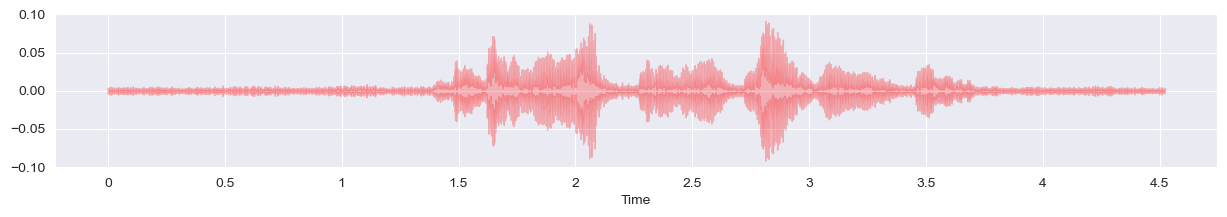

In [13]:
plt.figure(figsize=(15,2))
librosa.display.waveshow(y, sr=sr, alpha=0.25, color='r')

In [14]:
print('Signal mean = {:.5f}'.format(np.mean(abs(y))))
print('Signal std dev = {:.5f}'.format(np.std(y)))

Signal mean = 0.00601
Signal std dev = 0.01059


RMSE mean = 0.00747
RMSE std dev = 0.00750


/var/folders/2z/9zfdwvxd34j7l53zzdmt6pl80000gn/T/ipykernel_42194/3153641977.py:1: FutureWarning: Pass y=[0.00385309 0.00378589 0.00374295 ... 0.00310039 0.00295324 0.00281494] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rmse = librosa.feature.rms(y + 0.0001)[0]


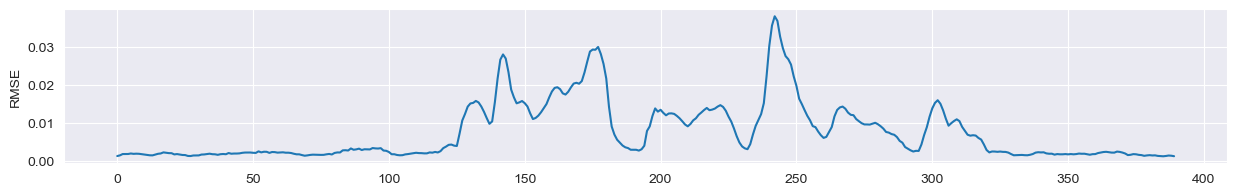

In [15]:
rmse = librosa.feature.rms(y + 0.0001)[0]
plt.figure(figsize=(15,2))
plt.plot(rmse)
plt.ylabel('RMSE')
print('RMSE mean = {:.5f}'.format(np.mean(rmse)))
print('RMSE std dev = {:.5f}'.format(np.std(rmse)))

In [16]:
from IPython.display import Audio
Audio(y, rate=44100)

In [17]:
silence = 0
for e in rmse:
    if e <= 0.4 * np.mean(rmse):
        silence += 1
print(silence/float(len(rmse)))

0.48205128205128206


In [18]:
y_harmonic, y_percussive = librosa.effects.hpss(y)
np.mean(y_harmonic)

-5.9714394e-06

In [19]:
autocorr = librosa.core.autocorrelate(y)
np.max(autocorr)

22.37459224905299

In [20]:
cl = 0.45 * np.mean(abs(y))
center_clipped = []
for s in y:
    if s >= cl:
        center_clipped.append(s - cl)
    elif s <= -cl:
        center_clipped.append(s + cl)
    elif np.abs(s) < cl:
        center_clipped.append(0)
new_autocorr = librosa.core.autocorrelate(np.array(center_clipped))
np.max(new_autocorr)

17.060244453036304

In [21]:
columns = ['wav_file', 'label', 'sig_mean', 'sig_std', 'rmse_mean', 'rmse_std', 'silence', 'harmonic', 'auto_corr_max', 'auto_corr_std']
df_features = pd.DataFrame(columns=columns)

The following blocks build feature vectors for all the files

In [7]:
emotion_dict = {'ang': 0, 
                'hap': 1, 
                'exc': 2,
                'sad': 3,
                'fru': 4,
                'fea': 5,
                'sur': 6,
                'neu': 7,
                'xxx': 8,
                'oth': 8}

data_dir = '../data/preprocessing/'
labels_path = '{}df_iemocap.csv'.format(data_dir)
audio_vectors_path_general = '{}audio_vectors_'.format(data_dir)

In [8]:
import pandas as pd
import numpy as np
import pickle
import librosa
from tqdm import tqdm

# Load the labels DataFrame
labels_df = pd.read_csv(labels_path)

# Initialize an empty list to store features
features_list = []

# Iterate through sessions and process each audio file
for sess in range(1, 6):
    audio_vectors_path = '{}{}.pkl'.format(audio_vectors_path_general, sess)
    with open(audio_vectors_path, 'rb') as f:
        audio_vectors = pickle.load(f)
        
    session_labels_df = labels_df[labels_df['wav_file'].str.contains(f'Ses0{sess}')]
    
    for index, row in tqdm(session_labels_df.iterrows(), total=session_labels_df.shape[0]):
        try:
            wav_file_name = row['wav_file']
            label = emotion_dict[row['emotion']]
            y = audio_vectors[wav_file_name]
            
            feature_list = [wav_file_name, label]
            
            # Calculate and append features
            sig_mean = np.mean(np.abs(y))
            feature_list.append(sig_mean)
            feature_list.append(np.std(y))
            
            rmse = librosa.feature.rms(y + 0.0001)[0]
            feature_list.append(np.mean(rmse))
            feature_list.append(np.std(rmse))
            
            silence = np.sum(rmse <= 0.4 * np.mean(rmse)) / len(rmse)
            feature_list.append(silence)
            
            y_harmonic = librosa.effects.hpss(y)[0]
            feature_list.append(np.mean(y_harmonic) * 1000)
            
            cl = 0.45 * sig_mean
            center_clipped = np.clip(y - cl, -cl, cl)
            center_clipped[np.abs(center_clipped) < cl] = 0
            auto_corrs = librosa.core.autocorrelate(center_clipped)
            feature_list.append(1000 * np.max(auto_corrs) / len(auto_corrs))
            feature_list.append(np.std(auto_corrs))
            
            # Append the feature list to the features_list
            features_list.append(feature_list)
        except Exception as e:
            print(f'Some exception occurred: {e}')

# Convert the list of features into a DataFrame
columns = [
    'wav_file', 'label', 'sig_mean', 'sig_std', 'rmse_mean', 'rmse_std',
    'silence', 'harmonic', 'auto_corr_max', 'auto_corr_std'
]
df_features = pd.DataFrame(features_list, columns=columns)

# Save the DataFrame to a CSV file
# df_features.to_csv('../data/preprocessing/audio_features.csv', index=False)


  0%|          | 0/1819 [00:00<?, ?it/s]/var/folders/2z/9zfdwvxd34j7l53zzdmt6pl80000gn/T/ipykernel_64177/148446825.py:34: FutureWarning: Pass y=[ 0.0046615   0.00472905  0.00459052 ... -0.00773007 -0.00569558
 -0.00539895] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rmse = librosa.feature.rms(y + 0.0001)[0]
  0%|          | 1/1819 [00:00<13:08,  2.31it/s]/var/folders/2z/9zfdwvxd34j7l53zzdmt6pl80000gn/T/ipykernel_64177/148446825.py:34: FutureWarning: Pass y=[-0.00208087 -0.00215503 -0.00212482 ... -0.00460845 -0.00438017
 -0.00409489] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rmse = librosa.feature.rms(y + 0.0001)[0]
  0%|          | 2/1819 [00:00<08:23,  3.61it/s]/var/folders/2z/9zfdwvxd34j7l53zzdmt6pl80000gn/T/ipykernel_64177/148446825.py:34: FutureWarning: Pass y=[ 0.04622994  0.04300304  0.03974907 ... -0.04170747 -0.03693342
 -0.03052158] as keyword args. From version 0.1

KeyboardInterrupt: 

In [12]:
y

array([-0.00332607, -0.0032988 , -0.0032802 , ...,  0.00639809,
        0.00726097,  0.00852667], dtype=float32)

In [24]:
import pandas as pd
import numpy as np
import pickle
import librosa
from tqdm import tqdm

# Define the number of MFCCs to extract
n_mfcc = 13
n_mels = 128  # Number of Mel bands


# Load the labels DataFrame
labels_df = pd.read_csv(labels_path)

# Initialize an empty list to store features
features_list = []

# Iterate through sessions and process each audio file
for sess in range(1, 6):
    audio_vectors_path = '{}{}.pkl'.format(audio_vectors_path_general, sess)
    with open(audio_vectors_path, 'rb') as f:
        audio_vectors = pickle.load(f)
        
    session_labels_df = labels_df[labels_df['wav_file'].str.contains(f'Ses0{sess}')]
    
    for index, row in tqdm(session_labels_df.iterrows(), total=session_labels_df.shape[0]):
        try:
            wav_file_name = row['wav_file']
            label = emotion_dict[row['emotion']]
            y = audio_vectors[wav_file_name]
            
            feature_list = [wav_file_name, label]
            
            # Calculate and append features
            sig_mean = np.mean(np.abs(y))
            feature_list.append(sig_mean)
            feature_list.append(np.std(y))
            
            rmse = librosa.feature.rms(y + 0.0001)[0]
            feature_list.append(np.mean(rmse))
            feature_list.append(np.std(rmse))
            
            silence = np.sum(rmse <= 0.4 * np.mean(rmse)) / len(rmse)
            feature_list.append(silence)
            
            y_harmonic = librosa.effects.hpss(y)[0]
            feature_list.append(np.mean(y_harmonic) * 1000)
            
            cl = 0.45 * sig_mean
            center_clipped = np.clip(y - cl, -cl, cl)
            center_clipped[np.abs(center_clipped) < cl] = 0
            auto_corrs = librosa.core.autocorrelate(center_clipped)
            feature_list.append(1000 * np.max(auto_corrs) / len(auto_corrs))
            feature_list.append(np.std(auto_corrs))
            
            # Calculate MFCCs and append the mean and standard deviation of each coefficient
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
            for i in range(n_mfcc):
                feature_list.append(np.mean(mfccs[i]))
                feature_list.append(np.std(mfccs[i]))
            
            # Calculate Mel spectrogram and append its statistics
            mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
            mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
            feature_list.append(np.mean(mel_spectrogram_db))
            feature_list.append(np.std(mel_spectrogram_db))
            
            # Append the feature list to the features_list
            features_list.append(feature_list)
            
            # Append the feature list to the features_list
            features_list.append(feature_list)
        except Exception as e:
            print(f'Some exception occurred: {e}')


  0%|          | 0/1819 [00:00<?, ?it/s]/var/folders/2z/9zfdwvxd34j7l53zzdmt6pl80000gn/T/ipykernel_42194/1945027967.py:39: FutureWarning: Pass y=[ 0.0046615   0.00472905  0.00459052 ... -0.00773007 -0.00569558
 -0.00539895] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rmse = librosa.feature.rms(y + 0.0001)[0]
  0%|          | 1/1819 [00:00<04:08,  7.32it/s]/var/folders/2z/9zfdwvxd34j7l53zzdmt6pl80000gn/T/ipykernel_42194/1945027967.py:39: FutureWarning: Pass y=[-0.00208087 -0.00215503 -0.00212482 ... -0.00460845 -0.00438017
 -0.00409489] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rmse = librosa.feature.rms(y + 0.0001)[0]
  0%|          | 2/1819 [00:00<05:46,  5.24it/s]/var/folders/2z/9zfdwvxd34j7l53zzdmt6pl80000gn/T/ipykernel_42194/1945027967.py:39: FutureWarning: Pass y=[ 0.04622994  0.04300304  0.03974907 ... -0.04170747 -0.03693342
 -0.03052158] as keyword args. From version 

Some exception occurred: 'dis'


 31%|███       | 556/1819 [03:54<07:56,  2.65it/s]/var/folders/2z/9zfdwvxd34j7l53zzdmt6pl80000gn/T/ipykernel_42194/1945027967.py:39: FutureWarning: Pass y=[ 0.00133903  0.00174844  0.0022263  ... -0.0008562  -0.00103414
 -0.0008731 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rmse = librosa.feature.rms(y + 0.0001)[0]
 31%|███       | 557/1819 [03:54<06:55,  3.04it/s]/var/folders/2z/9zfdwvxd34j7l53zzdmt6pl80000gn/T/ipykernel_42194/1945027967.py:39: FutureWarning: Pass y=[ 4.9555837e-03  4.0594912e-03  3.1689378e-03 ...  3.5845827e-05
 -6.5340106e-03 -1.4712641e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rmse = librosa.feature.rms(y + 0.0001)[0]
 31%|███       | 558/1819 [03:55<08:21,  2.52it/s]/var/folders/2z/9zfdwvxd34j7l53zzdmt6pl80000gn/T/ipykernel_42194/1945027967.py:39: FutureWarning: Pass y=[-0.00345526 -0.00371946 -0.00403807 ... -0.0010434  -0.00058723
 -0.00029624

Some exception occurred: 'dis'


 86%|████████▌ | 1838/2136 [20:01<02:14,  2.22it/s]/var/folders/2z/9zfdwvxd34j7l53zzdmt6pl80000gn/T/ipykernel_42194/1945027967.py:39: FutureWarning: Pass y=[0.00125998 0.0011748  0.00102368 ... 0.0007999  0.00088241 0.00093991] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rmse = librosa.feature.rms(y + 0.0001)[0]
 86%|████████▌ | 1839/2136 [20:02<02:24,  2.05it/s]/var/folders/2z/9zfdwvxd34j7l53zzdmt6pl80000gn/T/ipykernel_42194/1945027967.py:39: FutureWarning: Pass y=[-1.5281767e-03 -1.3644838e-03 -1.2225596e-03 ... -3.2606613e-04
 -5.2111158e-05  2.4676407e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rmse = librosa.feature.rms(y + 0.0001)[0]
 86%|████████▌ | 1840/2136 [20:02<02:17,  2.16it/s]/var/folders/2z/9zfdwvxd34j7l53zzdmt6pl80000gn/T/ipykernel_42194/1945027967.py:39: FutureWarning: Pass y=[ 0.00026539  0.00027753  0.0002829  ... -0.00073694 -0.00068086
 -0.00067751] as

Some exception occurred: zero-size array to reduction operation maximum which has no identity
Some exception occurred: zero-size array to reduction operation maximum which has no identity
Some exception occurred: zero-size array to reduction operation maximum which has no identity


 28%|██▊       | 607/2170 [04:46<04:14,  6.15it/s]/var/folders/2z/9zfdwvxd34j7l53zzdmt6pl80000gn/T/ipykernel_42194/1945027967.py:39: FutureWarning: Pass y=[-0.00052474 -0.00047225 -0.00044167 ... -0.0033021  -0.00312103
 -0.00295036] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rmse = librosa.feature.rms(y + 0.0001)[0]
 28%|██▊       | 608/2170 [04:46<04:51,  5.36it/s]/var/folders/2z/9zfdwvxd34j7l53zzdmt6pl80000gn/T/ipykernel_42194/1945027967.py:39: FutureWarning: Pass y=[ 1.4725073e-04  9.9401295e-05  6.5000233e-05 ... -2.9170903e-04
 -5.2873400e-04 -9.2382968e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rmse = librosa.feature.rms(y + 0.0001)[0]
 28%|██▊       | 609/2170 [04:47<07:35,  3.43it/s]/var/folders/2z/9zfdwvxd34j7l53zzdmt6pl80000gn/T/ipykernel_42194/1945027967.py:39: FutureWarning: Pass y=[ 0.00049711  0.00050841  0.00053403 ... -0.00162705 -0.00177438
 -0.0018966 

Some exception occurred: zero-size array to reduction operation maximum which has no identity
Some exception occurred: zero-size array to reduction operation maximum which has no identity
Some exception occurred: zero-size array to reduction operation maximum which has no identity


 30%|██▉       | 649/2170 [05:05<06:07,  4.14it/s]/var/folders/2z/9zfdwvxd34j7l53zzdmt6pl80000gn/T/ipykernel_42194/1945027967.py:39: FutureWarning: Pass y=[ 2.2453078e-04  6.8250170e-05 -1.0933384e-04 ...  2.1033370e-04
  2.9686271e-04  3.0095805e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rmse = librosa.feature.rms(y + 0.0001)[0]
 30%|██▉       | 650/2170 [05:05<06:02,  4.19it/s]/var/folders/2z/9zfdwvxd34j7l53zzdmt6pl80000gn/T/ipykernel_42194/1945027967.py:39: FutureWarning: Pass y=[ 0.00224155  0.00029824 -0.00130725 ...  0.01890589  0.01772834
  0.01725183] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rmse = librosa.feature.rms(y + 0.0001)[0]
 30%|███       | 651/2170 [05:06<05:31,  4.59it/s]/var/folders/2z/9zfdwvxd34j7l53zzdmt6pl80000gn/T/ipykernel_42194/1945027967.py:39: FutureWarning: Pass y=[-0.01046126 -0.01302808 -0.01524007 ...  0.00062208  0.00078472
  0.00084424

ValueError: 10 columns passed, passed data had 38 columns

In [28]:
# len(features_list[0])

38

In [29]:

columns = [
    'wav_file', 'label', 'sig_mean', 'sig_std', 'rmse_mean', 'rmse_std',
    'silence', 'harmonic', 'auto_corr_max', 'auto_corr_std'
] + [f'mfcc_{i+1}_mean' for i in range(n_mfcc)] + [f'mfcc_{i+1}_std' for i in range(n_mfcc)] + ['mel_mean', 'mel_std']


# Convert the list of features into a DataFrame
df_features = pd.DataFrame(features_list, columns=columns)

# Save the DataFrame to a CSV file
df_features.to_csv('../data/preprocessing/audio_features_wiz_mcc_mel.csv', index=False)